In [133]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

In [134]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout, BatchNormalization, LSTM, GRU, Embedding,Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import EarlyStopping 

## ATTEMPT AT TUNING NEURAL NETWORK PARAMETERS 

In [135]:
df = pd.read_csv('model_data/aggregateddata.csv',index_col=0)

In [136]:
df['total_individuals_fully_vaccinated']= df['total_individuals_fully_vaccinated'].replace(np.nan,0)

In [137]:
df.head()

,report_date,ICU,ICU_vented,hospitalizations,icu_crci_total,icu_crci_total_vented,total_doses_in_fully_vaccinated_individuals,total_individuals_fully_vaccinated,Daily_Covid_Num,Cum_Covid_Numbers
0,2020-12-24,277,176,967,297,188,NaN,0.0,844,58584
1,2020-12-30,323,204,1230,342,212,NaN,0.0,856,63599
2,2020-12-31,337,210,1270,354,219,NaN,0.0,853,64452
3,2021-01-01,336,221,1269,355,232,NaN,0.0,956,65408
4,2021-01-02,322,220,1287,344,230,NaN,0.0,938,66346


In [138]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [139]:
df['report_date'] = pd.to_datetime(df['report_date'])

In [140]:
df = df.drop(['total_doses_in_fully_vaccinated_individuals','Cum_Covid_Numbers'],axis=1)

In [141]:
cols = df.columns.tolist()
cols 

['report_date',
 'ICU',
 'ICU_vented',
 'hospitalizations',
 'icu_crci_total',
 'icu_crci_total_vented',
 'total_individuals_fully_vaccinated',
 'Daily_Covid_Num']

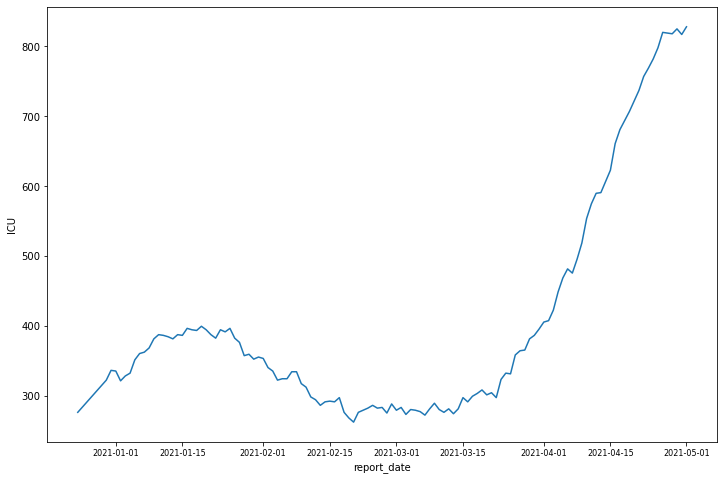

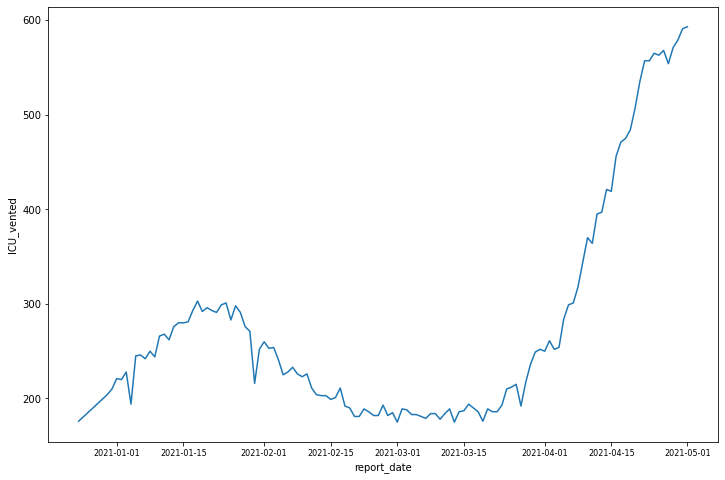

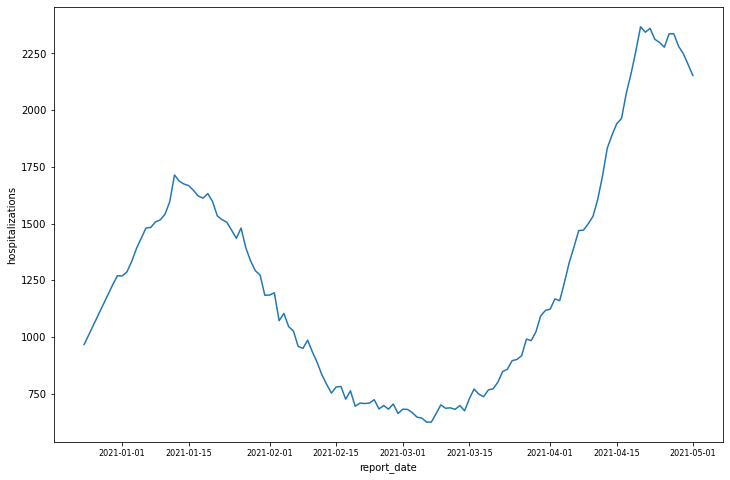

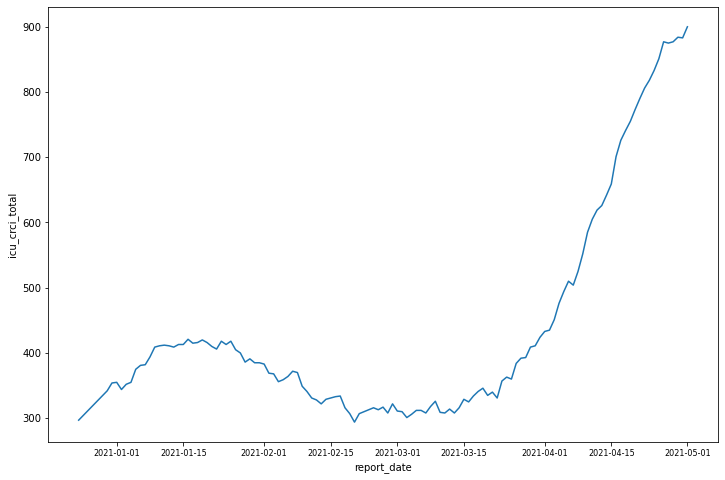

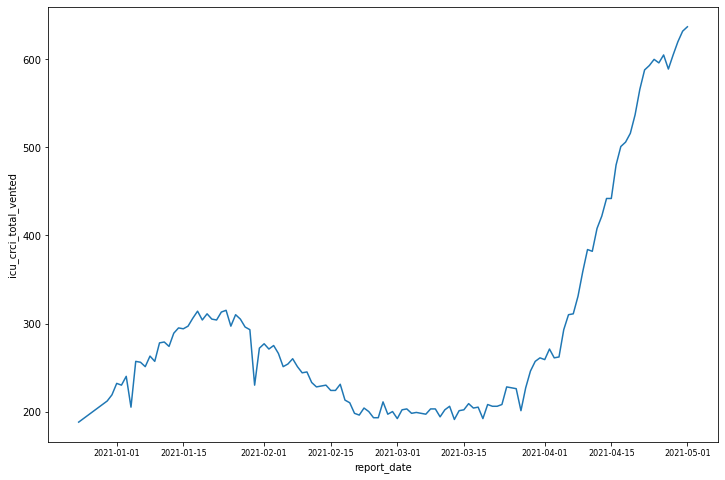

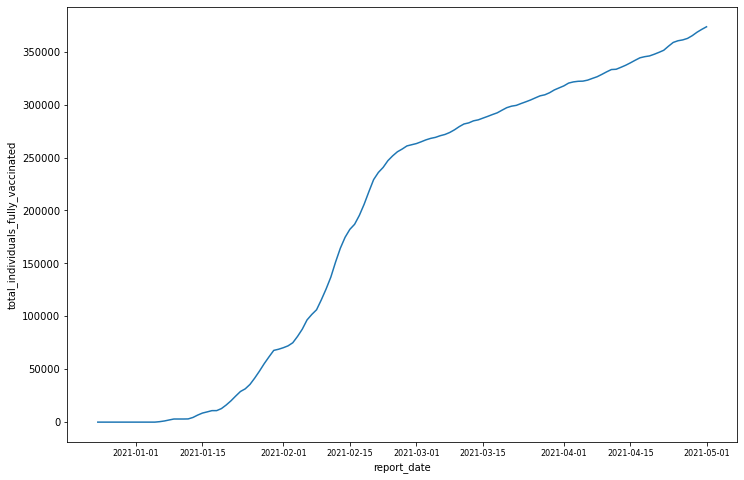

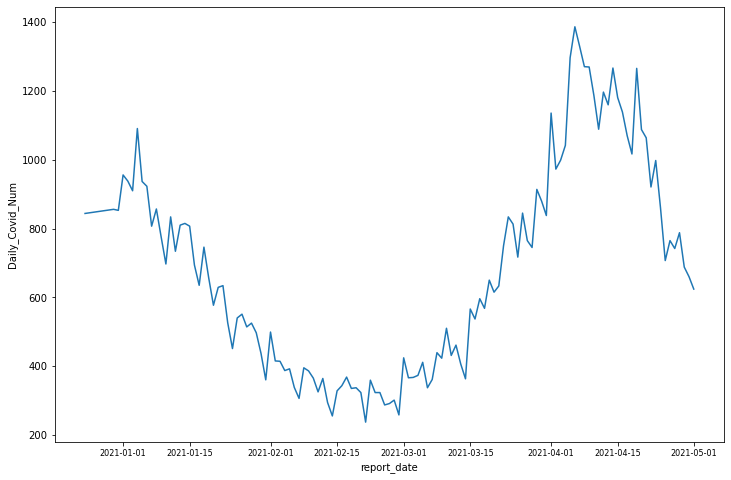

In [142]:
for i in range(1,len(cols)):
    plt.figure(figsize=(12,8))
    sns.lineplot(x='report_date',y=cols[i], data=df)
    plt.xticks(fontsize=8)
    plt.show()



In [143]:
n_days = 4

In [144]:
df[cols[1:]][:-4]

,ICU,ICU_vented,hospitalizations,icu_crci_total,icu_crci_total_vented,total_individuals_fully_vaccinated,Daily_Covid_Num
0,277,176,967,297,188,0.0,844
1,323,204,1230,342,212,0.0,856
2,337,210,1270,354,219,0.0,853
3,336,221,1269,355,232,0.0,956
4,322,220,1287,344,230,0.0,938
...,...,...,...,...,...,...,...
115,769,557,2312,818,593,355208.0,998
116,782,565,2298,833,600,358776.0,861
117,798,563,2277,851,596,360354.0,707
118,820,568,2336,877,605,361166.0,765


In [145]:
train_df  = df[cols[1:]][:-4].astype(float)

test_df =  df[cols[1:]][-4:].astype(float)

In [146]:
print(train_df.shape)
print(test_df.shape)

(120, 7)
(4, 7)


In [147]:
scaler = MinMaxScaler()

scaled_train_df = scaler.fit_transform(train_df)

In [148]:
n_forecast = 8 #days to forecast
n_past = 90 #past days to  learn from 

In [171]:
train_X=[]
train_Y = []


for i in range(n_past,len(train_df)+1 - n_forecast):
    train_X.append(scaled_train_df[i-n_past:i, 0:scaled_train_df.shape[1]])
    train_Y.append(scaled_train_df[i+n_forecast-1:i+n_forecast,0:scaled_train_df.shape[1]])

In [172]:
train_X,train_Y = np.array(train_X), np.array(train_Y)

In [173]:
train_X.shape

(23, 90, 7)

In [174]:
scaled_train_df.shape[1]

7

In [175]:
train_Y.shape

(23, 1, 7)

In [288]:
#train_Y

In [318]:
import kerastuner as kt 

In [345]:
def buildmodel(layer):
    model = Sequential()
    layer_unit = layer.Int('units',min_value=8, max_value=128, step=16)
    model.add(LSTM(units=layer_unit,activation='relu', input_shape=(train_X.shape[1],train_X.shape[2]),return_sequences=True))
    layer_unit2 = layer.Int('units_2',min_value=8, max_value=128, step=16)
    model.add(LSTM(units=layer_unit2,activation='relu',return_sequences=True))
    model.add(Dropout(0.2))
    layer_unit3 = layer.Int('units_3',min_value=8, max_value=128, step=16)
    model.add(LSTM(units=layer_unit3,activation='relu',return_sequences=True))
    #model.add(Dropout(0.2))
    layer_unit4 = layer.Int('units_4',min_value=8, max_value=128, step=16)
    model.add(LSTM(units=layer_unit4,activation='relu',return_sequences=False))
    #model.add(Dropout(0.2))
    model.add(Dense(train_Y.shape[2]))
    layer_learning_rate = layer.Choice('learning_rate',values=[1e-2,1e-3,1e-4])
    model.compile(optimizer=Adam(learning_rate=layer_learning_rate),loss='mse')
    return model 


tuner = kt.Hyperband(buildmodel,objective='val_loss',max_epochs=20,factor=3,project_name='intro_to_kt_2')

early_stop = EarlyStopping(monitor='val_loss',patience=10,mode='min')

tuner.search(train_X,train_Y,epochs=50,validation_split=0.15,callbacks=[early_stop])

best_parms = tuner.get_best_hyperparameters(num_trials=1)[0]

In [350]:
best_parms.get('units')

88

In [351]:
best_parms.get('units_2')

104

In [352]:
best_parms.get('units_4')

120

In [326]:
best_parms.get('learning_rate')

0.001

In [177]:
#Building Models : Basic LSTM


In [269]:
# model = Sequential()
# model.add(LSTM(64,activation='relu', input_shape=(train_X.shape[1],train_X.shape[2]),return_sequences=True))
# model.add(LSTM(32,activation='relu',return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(16,activation='relu',return_sequences=True))
# #model.add(Dropout(0.2))
# model.add(LSTM(8,activation='relu',return_sequences=False))
# #model.add(Dropout(0.2))
# model.add(Dense(train_Y.shape[2]))
# model.compile(optimizer='adam',loss='mse')

In [353]:
#model.summary()

In [354]:
early_stop = EarlyStopping(monitor='val_loss',patience=25,mode='min')

In [355]:
model = tuner.hypermodel.build(best_parms)

In [356]:
history = model.fit(train_X,train_Y,epochs=1000,batch_size=8, validation_split=0.15, verbose=1,callbacks=[early_stop])

Epoch 1/1000
3/3 [==============================] - ETA: 0s - loss: 0.514 - ETA: 0s - loss: 0.540 - ETA: 0s - loss: 0.536 - 1s 233ms/step - loss: 0.5362 - val_loss: 0.8216
Epoch 2/1000
3/3 [==============================] - ETA: 0s - loss: 0.447 - ETA: 0s - loss: 0.518 - ETA: 0s - loss: 0.511 - 0s 92ms/step - loss: 0.5113 - val_loss: 0.7647
Epoch 3/1000
3/3 [==============================] - ETA: 0s - loss: 0.509 - ETA: 0s - loss: 0.484 - ETA: 0s - loss: 0.467 - 0s 90ms/step - loss: 0.4678 - val_loss: 0.6272
Epoch 4/1000
3/3 [==============================] - ETA: 0s - loss: 0.366 - ETA: 0s - loss: 0.371 - ETA: 0s - loss: 0.358 - 0s 91ms/step - loss: 0.3581 - val_loss: 0.2046
Epoch 5/1000
3/3 [==============================] - ETA: 0s - loss: 0.160 - ETA: 0s - loss: 0.123 - ETA: 0s - loss: 0.136 - 0s 93ms/step - loss: 0.1361 - val_loss: 0.0852
Epoch 6/1000
3/3 [==============================] - ETA: 0s - loss: 0.069 - ETA: 0s - loss: 0.079 - ETA: 0s - loss: 0.087 - 0s 90ms/step - loss:

<AxesSubplot:>

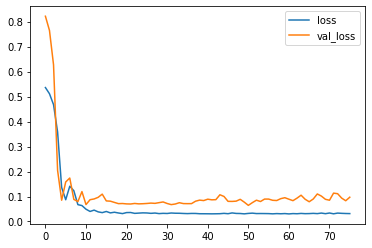

In [357]:
losses= pd.DataFrame(history.history)
losses.plot()

In [358]:
forecast = model.predict(train_X[-n_forecast:])

In [359]:
forecast.shape

(8, 7)

In [360]:
def forecaster(forecast):
    forecast_cop = forecast
    #np.repeat(forecast,train_df.shape[1],axis=-1)
    forecast_dates = pd.date_range(list(df['report_date'])[-n_forecast], periods =n_forecast, freq='1d').tolist()
    
    y_pred_future = scaler.inverse_transform(forecast_cop)
    
    dates=[]
    for time_ in forecast_dates:
        dates.append(time_.date())
    
    df_forecast = pd.concat([pd.DataFrame({'dates':dates}),pd.DataFrame(y_pred_future)],axis=1)
    
    return df_forecast
    

In [361]:
def Model_forecast(model):
    forecast = model.predict(train_X[-n_forecast:])
    df_forecast = forecaster(forecast)
    df_forecast.columns = df.columns
    df_forecast['report_date']= pd.to_datetime(df_forecast['report_date'])
    return df_forecast

In [362]:
def accuracy_score(forecast,actual):
    rmse = np.sqrt(np.mean((forecast - actual)**2))
    mape = 100 * np.mean(np.abs(forecast - actual)/np.abs(actual))
    merr = np.mean(np.abs(forecast - actual))
    
    return ({'mean_absolute_pcnt_error':f'{np.round(mape,2)} %', 'root_mean_squared_error' : rmse, 'mean_absolute_error':merr})

In [363]:
df_forecast= Model_forecast(model)
df_forecast

,report_date,ICU,ICU_vented,hospitalizations,icu_crci_total,icu_crci_total_vented,total_individuals_fully_vaccinated,Daily_Covid_Num
0,2021-04-24,617.596191,416.072235,1857.072876,653.799438,438.255127,339700.65625,1173.343384
1,2021-04-25,619.550598,416.953735,1862.520508,655.470337,439.355164,341137.50000,1176.532837
2,2021-04-26,621.471680,417.796570,1867.873413,657.103271,440.423126,342536.87500,1179.614502
3,2021-04-27,623.360046,418.605164,1873.148071,658.700134,441.461884,343904.37500,1182.605103
4,2021-04-28,625.217102,419.385651,1878.376831,660.258362,442.475616,345246.37500,1185.527100
5,2021-04-29,627.041199,420.161804,1883.653442,661.776489,443.479462,346581.12500,1188.436768
6,2021-04-30,628.849915,420.953827,1889.042725,663.268860,444.493225,347930.75000,1191.398804
7,2021-05-01,630.662170,421.783020,1894.615356,664.754822,445.535736,349316.71875,1194.473755


In [364]:
df.tail(n_forecast)

,report_date,ICU,ICU_vented,hospitalizations,icu_crci_total,icu_crci_total_vented,total_individuals_fully_vaccinated,Daily_Covid_Num
116,2021-04-24,782,565,2298,833,600,358776.0,861
117,2021-04-25,798,563,2277,851,596,360354.0,707
118,2021-04-26,820,568,2336,877,605,361166.0,765
119,2021-04-27,819,554,2336,875,589,362563.0,742
120,2021-04-28,818,571,2281,877,605,365166.0,788
121,2021-04-29,825,579,2248,884,620,368403.0,688
122,2021-04-30,817,591,2201,883,632,371110.0,660
123,2021-05-01,828,593,2152,900,637,373559.0,624


In [367]:

for i in range(1,len(df_forecast.columns)):
    print('\n')
    print(f'printing the accuracy score of {df_forecast.columns[i]}')
    score= accuracy_score(df.tail(8).iloc[1:,i],df_forecast.iloc[1:,i].values)
    print('----------------------------------------------')
    print(score)

#list(df['report_date'])[-4:]

#forecast_dates = pd.date_range(list(df['report_date'])[-8], periods =8, freq='1d').tolist()

#forecast_dates
# df_forecast = forecaster(forecast)

# df_forecast.columns = df.columns

# df_forecast['report_date']= pd.to_datetime(df_forecast['report_date'])

# df_forecast

#df.tail(8)



printing the accuracy score of ICU
----------------------------------------------
{'mean_absolute_pcnt_error': '30.82 %', 'root_mean_squared_error': 192.80941027050935, 'mean_absolute_error': 192.69247000558036}


printing the accuracy score of ICU_vented
----------------------------------------------
{'mean_absolute_pcnt_error': '36.9 %', 'root_mean_squared_error': 155.227842762968, 'mean_absolute_error': 154.7657470703125}


printing the accuracy score of hospitalizations
----------------------------------------------
{'mean_absolute_pcnt_error': '20.41 %', 'root_mean_squared_error': 389.7958596417998, 'mean_absolute_error': 383.10995047433033}


printing the accuracy score of icu_crci_total
----------------------------------------------
{'mean_absolute_pcnt_error': '33.01 %', 'root_mean_squared_error': 218.22476831465582, 'mean_absolute_error': 217.95253208705358}


printing the accuracy score of icu_crci_total_vented
----------------------------------------------
{'mean_absolute_

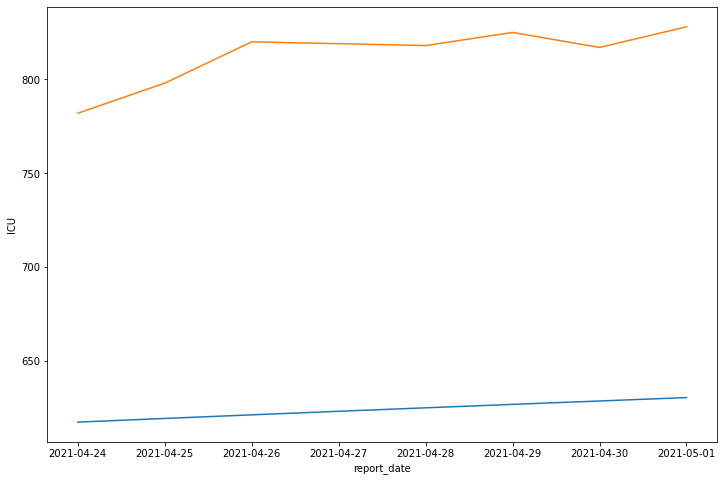

In [368]:
plt.figure(figsize=(12,8))
sns.lineplot(x='report_date',y='ICU',data=df_forecast )
sns.lineplot(x='report_date',y='ICU',data=df.tail(8) )
plt.show()

In [369]:

# for i in range(1,len(df_forecast.columns)):
#     print('\n')
#     print(f'printing the accuracy score of {df_forecast.columns[i]}')
#     score= accuracy_score(df.tail(8).iloc[1:,i],df_forecast.iloc[1:,i].values)
#     print('----------------------------------------------')
#     print(score)
    

In [377]:
def buildmodel(layer):
    model = Sequential()
    layer_cnnunit = layer.Int('cnn_units',min_value=8, max_value=128, step=16)
    model.add(Conv1D(filters=layer_cnnunit,activation='relu',kernel_size=(3),input_shape=(train_X.shape[1],train_X.shape[2])))
    model.add(MaxPooling1D(pool_size=3,padding='same'))
    layer_cnnunit2 = layer.Int('cnn_units2',min_value=8, max_value=128, step=16)
    model.add(Conv1D(filters=layer_cnnunit2,activation='relu',kernel_size=(3)))
    model.add(MaxPooling1D(pool_size=3,padding='same'))

    layer_unit = layer.Int('units',min_value=8, max_value=128, step=16)
    model.add(LSTM(units=layer_unit,activation='relu',return_sequences=True))
    model.add(Dropout(0.2))
    layer_unit2 = layer.Int('units_2',min_value=8, max_value=128, step=16)
    model.add(LSTM(units=layer_unit2,activation='relu',return_sequences=True))
    layer_unit3 = layer.Int('units_3',min_value=8, max_value=128, step=16)
    model.add(LSTM(units=layer_unit3,activation='relu',return_sequences=True))
    layer_unit4 = layer.Int('units_4',min_value=8, max_value=128, step=16)
    model.add(LSTM(units=layer_unit4,activation='relu',return_sequences=False))
    model.add(Dense(train_Y.shape[2]))
    layer_learning_rate = layer.Choice('learning_rate',values=[1e-2,1e-3,1e-4])
    model.compile(optimizer=Adam(learning_rate=layer_learning_rate),loss='mse')
    return model 

In [378]:
tuner = kt.Hyperband(buildmodel,objective='val_loss',max_epochs=20,factor=3,project_name='optmodel_2b')

early_stop = EarlyStopping(monitor='val_loss',patience=10,mode='min')

In [379]:
tuner.search(train_X,train_Y,epochs=50,validation_split=0.15,callbacks=[early_stop])

Epoch 1/3
1/1 [==============================] - ETA: 0s - loss: 0.540 - 1s 511ms/step - loss: 0.5407 - val_loss: 0.8526
Epoch 2/3
1/1 [==============================] - ETA: 0s - loss: 0.540 - 0s 67ms/step - loss: 0.5402 - val_loss: 0.8519
Epoch 3/3
1/1 [==============================] - ETA: 0s - loss: 0.539 - 0s 70ms/step - loss: 0.5397 - val_loss: 0.8513


Epoch 1/3
1/1 [==============================] - ETA: 0s - loss: 0.539 - 1s 653ms/step - loss: 0.5390 - val_loss: 0.4722
Epoch 2/3
1/1 [==============================] - ETA: 0s - loss: 0.278 - 0s 58ms/step - loss: 0.2782 - val_loss: 49152.3789
Epoch 3/3
1/1 [==============================] - ETA: 0s - loss: 72005.468 - 0s 111ms/step - loss: 72005.4688 - val_loss: 0.0666


Epoch 1/3
1/1 [==============================] - ETA: 0s - loss: 0.540 - 1s 554ms/step - loss: 0.5404 - val_loss: 0.7836
Epoch 2/3
1/1 [==============================] - ETA: 0s - loss: 0.490 - 0s 85ms/step - loss: 0.4907 - val_loss: 0.5493
Epoch 3/3
1/1 [==============================] - ETA: 0s - loss: 0.326 - 0s 54ms/step - loss: 0.3267 - val_loss: 3.6036


Epoch 1/3
1/1 [==============================] - ETA: 0s - loss: 0.540 - 1s 519ms/step - loss: 0.5405 - val_loss: 0.7682
Epoch 2/3
1/1 [==============================] - ETA: 0s - loss: 0.477 - 0s 34ms/step - loss: 0.4772 - val_loss: 257.3726
Epoch 3/3
1/1 [==============================] - ETA: 0s - loss: 242.587 - 0s 71ms/step - loss: 242.5879 - val_loss: 0.5835


Epoch 1/3
1/1 [==============================] - ETA: 0s - loss: 0.541 - 1s 653ms/step - loss: 0.5412 - val_loss: 0.8512
Epoch 2/3
1/1 [==============================] - ETA: 0s - loss: 0.539 - 0s 110ms/step - loss: 0.5397 - val_loss: 0.8483
Epoch 3/3
1/1 [==============================] - ETA: 0s - loss: 0.537 - 0s 87ms/step - loss: 0.5376 - val_loss: 0.8460


Epoch 1/3
1/1 [==============================] - ETA: 0s - loss: 0.540 - 1s 517ms/step - loss: 0.5400 - val_loss: 0.8466
Epoch 2/3
1/1 [==============================] - ETA: 0s - loss: 0.535 - 0s 66ms/step - loss: 0.5353 - val_loss: 0.8400
Epoch 3/3
1/1 [==============================] - ETA: 0s - loss: 0.530 - 0s 76ms/step - loss: 0.5300 - val_loss: 0.8327


Epoch 1/3
1/1 [==============================] - ETA: 0s - loss: 0.539 - 1s 520ms/step - loss: 0.5398 - val_loss: 0.8439
Epoch 2/3
1/1 [==============================] - ETA: 0s - loss: 0.533 - 0s 70ms/step - loss: 0.5335 - val_loss: 0.8359
Epoch 3/3
1/1 [==============================] - ETA: 0s - loss: 0.526 - 0s 69ms/step - loss: 0.5268 - val_loss: 0.8261


Epoch 1/3
1/1 [==============================] - ETA: 0s - loss: 0.540 - 1s 522ms/step - loss: 0.5402 - val_loss: 0.8442
Epoch 2/3
1/1 [==============================] - ETA: 0s - loss: 0.533 - 0s 71ms/step - loss: 0.5339 - val_loss: 0.8355
Epoch 3/3
1/1 [==============================] - ETA: 0s - loss: 0.527 - 0s 73ms/step - loss: 0.5270 - val_loss: 0.8249


Epoch 1/3
1/1 [==============================] - ETA: 0s - loss: 0.540 - 1s 526ms/step - loss: 0.5404 - val_loss: 0.8470
Epoch 2/3
1/1 [==============================] - ETA: 0s - loss: 0.536 - 0s 66ms/step - loss: 0.5360 - val_loss: 0.8412
Epoch 3/3
1/1 [==============================] - ETA: 0s - loss: 0.531 - 0s 68ms/step - loss: 0.5313 - val_loss: 0.8349


Epoch 1/3
1/1 [==============================] - ETA: 0s - loss: 0.539 - 1s 546ms/step - loss: 0.5397 - val_loss: 0.8504
Epoch 2/3
1/1 [==============================] - ETA: 0s - loss: 0.539 - 0s 106ms/step - loss: 0.5391 - val_loss: 0.8495
Epoch 3/3
1/1 [==============================] - ETA: 0s - loss: 0.538 - 0s 100ms/step - loss: 0.5385 - val_loss: 0.8486


Epoch 1/3
1/1 [==============================] - ETA: 0s - loss: 0.540 - 1s 510ms/step - loss: 0.5407 - val_loss: 0.8450
Epoch 2/3
1/1 [==============================] - ETA: 0s - loss: 0.534 - 0s 79ms/step - loss: 0.5346 - val_loss: 0.8379
Epoch 3/3
1/1 [==============================] - ETA: 0s - loss: 0.528 - 0s 101ms/step - loss: 0.5289 - val_loss: 0.8296


Epoch 1/3
1/1 [==============================] - ETA: 0s - loss: 0.540 - 1s 816ms/step - loss: 0.5405 - val_loss: 0.8469
Epoch 2/3
1/1 [==============================] - ETA: 0s - loss: 0.535 - 0s 67ms/step - loss: 0.5356 - val_loss: 0.8404
Epoch 3/3
1/1 [==============================] - ETA: 0s - loss: 0.530 - 0s 67ms/step - loss: 0.5300 - val_loss: 0.8332


Epoch 4/7
1/1 [==============================] - ETA: 0s - loss: 0.540 - 1s 523ms/step - loss: 0.5404 - val_loss: 0.6377
Epoch 5/7
1/1 [==============================] - ETA: 0s - loss: 0.365 - 0s 37ms/step - loss: 0.3654 - val_loss: 142.6790
Epoch 6/7
1/1 [==============================] - ETA: 0s - loss: 313.472 - 0s 76ms/step - loss: 313.4728 - val_loss: 0.5334
Epoch 7/7
1/1 [==============================] - ETA: 0s - loss: 0.280 - 0s 36ms/step - loss: 0.2801 - val_loss: 0.7705


Epoch 4/7
1/1 [==============================] - ETA: 0s - loss: 0.539 - 1s 506ms/step - loss: 0.5397 - val_loss: 0.7584
Epoch 5/7
1/1 [==============================] - ETA: 0s - loss: 0.472 - 0s 67ms/step - loss: 0.4728 - val_loss: 0.3828
Epoch 6/7
1/1 [==============================] - ETA: 0s - loss: 0.239 - 0s 36ms/step - loss: 0.2395 - val_loss: 453.9987
Epoch 7/7
1/1 [==============================] - ETA: 0s - loss: 605.862 - 0s 69ms/step - loss: 605.8627 - val_loss: 0.1468


Epoch 4/7
1/1 [==============================] - ETA: 0s - loss: 0.541 - 1s 517ms/step - loss: 0.5418 - val_loss: 0.8124
Epoch 5/7
1/1 [==============================] - ETA: 0s - loss: 0.507 - 0s 73ms/step - loss: 0.5079 - val_loss: 0.6695
Epoch 6/7
1/1 [==============================] - ETA: 0s - loss: 0.391 - 0s 40ms/step - loss: 0.3913 - val_loss: 16.4617
Epoch 7/7
1/1 [==============================] - ETA: 0s - loss: 25.07 - 0s 73ms/step - loss: 25.0710 - val_loss: 0.5340


Epoch 4/7
1/1 [==============================] - ETA: 0s - loss: 0.540 - 1s 514ms/step - loss: 0.5407 - val_loss: 0.8456
Epoch 5/7
1/1 [==============================] - ETA: 0s - loss: 0.535 - 0s 70ms/step - loss: 0.5354 - val_loss: 0.8380
Epoch 6/7
1/1 [==============================] - ETA: 0s - loss: 0.529 - 0s 69ms/step - loss: 0.5295 - val_loss: 0.8286
Epoch 7/7
1/1 [==============================] - ETA: 0s - loss: 0.522 - 0s 72ms/step - loss: 0.5221 - val_loss: 0.8167


Epoch 8/20
1/1 [==============================] - ETA: 0s - loss: 0.541 - 1s 511ms/step - loss: 0.5419 - val_loss: 0.8188
Epoch 9/20
1/1 [==============================] - ETA: 0s - loss: 0.515 - 0s 68ms/step - loss: 0.5151 - val_loss: 0.7564
Epoch 10/20
1/1 [==============================] - ETA: 0s - loss: 0.466 - 0s 66ms/step - loss: 0.4669 - val_loss: 0.5847
Epoch 11/20
1/1 [==============================] - ETA: 0s - loss: 0.342 - 0s 39ms/step - loss: 0.3420 - val_loss: 1.4776
Epoch 12/20
1/1 [==============================] - ETA: 0s - loss: 1.607 - 0s 66ms/step - loss: 1.6076 - val_loss: 0.4731
Epoch 13/20
1/1 [==============================] - ETA: 0s - loss: 0.259 - 0s 38ms/step - loss: 0.2591 - val_loss: 0.6195
Epoch 14/20
1/1 [==============================] - ETA: 0s - loss: 0.360 - 0s 37ms/step - loss: 0.3606 - val_loss: 0.6600
Epoch 15/20
1/1 [==============================] - ETA: 0s - loss: 0.390 - 0s 41ms/step - loss: 0.3902 - val_loss: 0.6707
Epoch 16/20
1/1 [========

Epoch 8/20
1/1 [==============================] - ETA: 0s - loss: 0.541 - 1s 519ms/step - loss: 0.5412 - val_loss: 0.7673
Epoch 9/20
1/1 [==============================] - ETA: 0s - loss: 0.468 - 0s 76ms/step - loss: 0.4686 - val_loss: 0.2953
Epoch 10/20
1/1 [==============================] - ETA: 0s - loss: 0.161 - 0s 38ms/step - loss: 0.1616 - val_loss: 0.6168
Epoch 11/20
1/1 [==============================] - ETA: 0s - loss: 0.356 - 0s 35ms/step - loss: 0.3566 - val_loss: 0.6484
Epoch 12/20
1/1 [==============================] - ETA: 0s - loss: 0.388 - 0s 43ms/step - loss: 0.3882 - val_loss: 0.6083
Epoch 13/20
1/1 [==============================] - ETA: 0s - loss: 0.364 - 0s 40ms/step - loss: 0.3645 - val_loss: 0.5299
Epoch 14/20
1/1 [==============================] - ETA: 0s - loss: 0.316 - 0s 38ms/step - loss: 0.3163 - val_loss: 0.4026
Epoch 15/20
1/1 [==============================] - ETA: 0s - loss: 0.243 - 0s 77ms/step - loss: 0.2439 - val_loss: 0.2158
Epoch 16/20
1/1 [========

Epoch 1/7
1/1 [==============================] - ETA: 0s - loss: 0.540 - 1s 513ms/step - loss: 0.5404 - val_loss: 0.8468
Epoch 2/7
1/1 [==============================] - ETA: 0s - loss: 0.536 - 0s 65ms/step - loss: 0.5361 - val_loss: 0.8410
Epoch 3/7
1/1 [==============================] - ETA: 0s - loss: 0.531 - 0s 64ms/step - loss: 0.5315 - val_loss: 0.8346
Epoch 4/7
1/1 [==============================] - ETA: 0s - loss: 0.526 - 0s 67ms/step - loss: 0.5264 - val_loss: 0.8276
Epoch 5/7
1/1 [==============================] - ETA: 0s - loss: 0.520 - 0s 65ms/step - loss: 0.5209 - val_loss: 0.8197
Epoch 6/7
1/1 [==============================] - ETA: 0s - loss: 0.514 - 0s 67ms/step - loss: 0.5147 - val_loss: 0.8109
Epoch 7/7
1/1 [==============================] - ETA: 0s - loss: 0.507 - 0s 66ms/step - loss: 0.5078 - val_loss: 0.8009


Epoch 1/7
1/1 [==============================] - ETA: 0s - loss: 0.540 - 1s 516ms/step - loss: 0.5402 - val_loss: 0.8509
Epoch 2/7
1/1 [==============================] - ETA: 0s - loss: 0.539 - 0s 67ms/step - loss: 0.5395 - val_loss: 0.8501
Epoch 3/7
1/1 [==============================] - ETA: 0s - loss: 0.538 - 0s 67ms/step - loss: 0.5389 - val_loss: 0.8493
Epoch 4/7
1/1 [==============================] - ETA: 0s - loss: 0.538 - 0s 68ms/step - loss: 0.5383 - val_loss: 0.8485
Epoch 5/7
1/1 [==============================] - ETA: 0s - loss: 0.537 - 0s 70ms/step - loss: 0.5377 - val_loss: 0.8477
Epoch 6/7
1/1 [==============================] - ETA: 0s - loss: 0.537 - 0s 69ms/step - loss: 0.5371 - val_loss: 0.8469
Epoch 7/7
1/1 [==============================] - ETA: 0s - loss: 0.536 - 0s 67ms/step - loss: 0.5364 - val_loss: 0.8460


Epoch 1/7
1/1 [==============================] - ETA: 0s - loss: 0.540 - 1s 511ms/step - loss: 0.5408 - val_loss: 0.8469
Epoch 2/7
1/1 [==============================] - ETA: 0s - loss: 0.535 - 0s 65ms/step - loss: 0.5359 - val_loss: 0.8409
Epoch 3/7
1/1 [==============================] - ETA: 0s - loss: 0.531 - 0s 71ms/step - loss: 0.5312 - val_loss: 0.8341
Epoch 4/7
1/1 [==============================] - ETA: 0s - loss: 0.525 - 0s 69ms/step - loss: 0.5258 - val_loss: 0.8261
Epoch 5/7
1/1 [==============================] - ETA: 0s - loss: 0.519 - 0s 67ms/step - loss: 0.5197 - val_loss: 0.8169
Epoch 6/7
1/1 [==============================] - ETA: 0s - loss: 0.512 - 0s 68ms/step - loss: 0.5124 - val_loss: 0.8060
Epoch 7/7
1/1 [==============================] - ETA: 0s - loss: 0.503 - 0s 68ms/step - loss: 0.5039 - val_loss: 0.7932


Epoch 1/7
1/1 [==============================] - ETA: 0s - loss: 0.540 - 1s 522ms/step - loss: 0.5401 - val_loss: 0.7958
Epoch 2/7
1/1 [==============================] - ETA: 0s - loss: 0.491 - 0s 66ms/step - loss: 0.4912 - val_loss: 0.5598
Epoch 3/7
1/1 [==============================] - ETA: 0s - loss: 0.284 - 0s 38ms/step - loss: 0.2843 - val_loss: 574.9503
Epoch 4/7
1/1 [==============================] - ETA: 0s - loss: 742.570 - 0s 67ms/step - loss: 742.5707 - val_loss: 0.4306
Epoch 5/7
1/1 [==============================] - ETA: 0s - loss: 0.182 - 0s 38ms/step - loss: 0.1821 - val_loss: 0.6782
Epoch 6/7
1/1 [==============================] - ETA: 0s - loss: 0.385 - 0s 40ms/step - loss: 0.3856 - val_loss: 0.7542
Epoch 7/7
1/1 [==============================] - ETA: 0s - loss: 0.454 - 0s 37ms/step - loss: 0.4547 - val_loss: 0.7860


Epoch 1/7
1/1 [==============================] - ETA: 0s - loss: 0.540 - 1s 513ms/step - loss: 0.5405 - val_loss: 0.7415
Epoch 2/7
1/1 [==============================] - ETA: 0s - loss: 0.448 - 0s 78ms/step - loss: 0.4485 - val_loss: 0.1796
Epoch 3/7
1/1 [==============================] - ETA: 0s - loss: 0.050 - 0s 39ms/step - loss: 0.0502 - val_loss: 23585.0293
Epoch 4/7
1/1 [==============================] - ETA: 0s - loss: 45492.644 - 0s 36ms/step - loss: 45492.6445 - val_loss: 0.2002
Epoch 5/7
1/1 [==============================] - ETA: 0s - loss: 0.413 - 0s 37ms/step - loss: 0.4131 - val_loss: 0.4937
Epoch 6/7
1/1 [==============================] - ETA: 0s - loss: 0.259 - 0s 38ms/step - loss: 0.2596 - val_loss: 0.7109
Epoch 7/7
1/1 [==============================] - ETA: 0s - loss: 0.428 - 0s 37ms/step - loss: 0.4280 - val_loss: 0.7853


Epoch 1/7
1/1 [==============================] - ETA: 0s - loss: 0.540 - 1s 512ms/step - loss: 0.5406 - val_loss: 0.7834
Epoch 2/7
1/1 [==============================] - ETA: 0s - loss: 0.493 - 0s 69ms/step - loss: 0.4937 - val_loss: 0.4956
Epoch 3/7
1/1 [==============================] - ETA: 0s - loss: 0.313 - 0s 38ms/step - loss: 0.3139 - val_loss: 522.8351
Epoch 4/7
1/1 [==============================] - ETA: 0s - loss: 814.105 - 0s 75ms/step - loss: 814.1052 - val_loss: 0.2454
Epoch 5/7
1/1 [==============================] - ETA: 0s - loss: 0.191 - 0s 41ms/step - loss: 0.1916 - val_loss: 0.5809
Epoch 6/7
1/1 [==============================] - ETA: 0s - loss: 0.354 - 0s 40ms/step - loss: 0.3543 - val_loss: 0.6844
Epoch 7/7
1/1 [==============================] - ETA: 0s - loss: 0.419 - 0s 36ms/step - loss: 0.4191 - val_loss: 0.7259


Epoch 8/20
1/1 [==============================] - ETA: 0s - loss: 0.540 - 1s 513ms/step - loss: 0.5404 - val_loss: 0.7406
Epoch 9/20
1/1 [==============================] - ETA: 0s - loss: 0.449 - 0s 73ms/step - loss: 0.4493 - val_loss: 0.0989
Epoch 10/20
1/1 [==============================] - ETA: 0s - loss: 0.058 - 0s 36ms/step - loss: 0.0586 - val_loss: 0.4223
Epoch 11/20
1/1 [==============================] - ETA: 0s - loss: 0.202 - 0s 39ms/step - loss: 0.2025 - val_loss: 0.2712
Epoch 12/20
1/1 [==============================] - ETA: 0s - loss: 0.117 - 0s 37ms/step - loss: 0.1177 - val_loss: 0.2685
Epoch 13/20
1/1 [==============================] - ETA: 0s - loss: 0.266 - 0s 39ms/step - loss: 0.2663 - val_loss: 0.2420
Epoch 14/20
1/1 [==============================] - ETA: 0s - loss: 0.090 - 0s 38ms/step - loss: 0.0908 - val_loss: 0.3271
Epoch 15/20
1/1 [==============================] - ETA: 0s - loss: 0.144 - 0s 37ms/step - loss: 0.1448 - val_loss: 0.3374
Epoch 16/20
1/1 [========

Epoch 8/20
1/1 [==============================] - ETA: 0s - loss: 0.540 - 1s 509ms/step - loss: 0.5403 - val_loss: 0.7680
Epoch 9/20
1/1 [==============================] - ETA: 0s - loss: 0.478 - 0s 66ms/step - loss: 0.4781 - val_loss: 0.3316
Epoch 10/20
1/1 [==============================] - ETA: 0s - loss: 0.167 - 0s 38ms/step - loss: 0.1670 - val_loss: 10440.6602
Epoch 11/20
1/1 [==============================] - ETA: 0s - loss: 17645.353 - 0s 39ms/step - loss: 17645.3535 - val_loss: 0.4709
Epoch 12/20
1/1 [==============================] - ETA: 0s - loss: 0.982 - 0s 71ms/step - loss: 0.9825 - val_loss: 0.3305
Epoch 13/20
1/1 [==============================] - ETA: 0s - loss: 0.167 - 0s 32ms/step - loss: 0.1676 - val_loss: 0.5088
Epoch 14/20
1/1 [==============================] - ETA: 0s - loss: 0.285 - 0s 32ms/step - loss: 0.2857 - val_loss: 0.5784
Epoch 15/20
1/1 [==============================] - ETA: 0s - loss: 0.334 - 0s 33ms/step - loss: 0.3346 - val_loss: 0.6058
Epoch 16/20
1

Epoch 1/20
1/1 [==============================] - ETA: 0s - loss: 0.540 - 1s 516ms/step - loss: 0.5403 - val_loss: 0.7660
Epoch 2/20
1/1 [==============================] - ETA: 0s - loss: 0.471 - 0s 74ms/step - loss: 0.4714 - val_loss: 0.3784
Epoch 3/20
1/1 [==============================] - ETA: 0s - loss: 0.175 - 0s 46ms/step - loss: 0.1757 - val_loss: 2167.4917
Epoch 4/20
1/1 [==============================] - ETA: 0s - loss: 3801.90 - 0s 71ms/step - loss: 3801.9045 - val_loss: 0.1786
Epoch 5/20
1/1 [==============================] - ETA: 0s - loss: 0.070 - 0s 36ms/step - loss: 0.0709 - val_loss: 0.5863
Epoch 6/20
1/1 [==============================] - ETA: 0s - loss: 0.329 - 0s 35ms/step - loss: 0.3295 - val_loss: 0.7176
Epoch 7/20
1/1 [==============================] - ETA: 0s - loss: 0.433 - 0s 38ms/step - loss: 0.4332 - val_loss: 0.7740
Epoch 8/20
1/1 [==============================] - ETA: 0s - loss: 0.478 - 0s 37ms/step - loss: 0.4780 - val_loss: 0.8052
Epoch 9/20
1/1 [=======

Epoch 1/20
1/1 [==============================] - ETA: 0s - loss: 0.540 - 1s 516ms/step - loss: 0.5406 - val_loss: 0.8450
Epoch 2/20
1/1 [==============================] - ETA: 0s - loss: 0.534 - 0s 73ms/step - loss: 0.5343 - val_loss: 0.8372
Epoch 3/20
1/1 [==============================] - ETA: 0s - loss: 0.528 - 0s 71ms/step - loss: 0.5280 - val_loss: 0.8276
Epoch 4/20
1/1 [==============================] - ETA: 0s - loss: 0.520 - 0s 73ms/step - loss: 0.5202 - val_loss: 0.8155
Epoch 5/20
1/1 [==============================] - ETA: 0s - loss: 0.510 - 0s 73ms/step - loss: 0.5103 - val_loss: 0.8003
Epoch 6/20
1/1 [==============================] - ETA: 0s - loss: 0.498 - 0s 72ms/step - loss: 0.4980 - val_loss: 0.7806
Epoch 7/20
1/1 [==============================] - ETA: 0s - loss: 0.482 - 0s 77ms/step - loss: 0.4822 - val_loss: 0.7548
Epoch 8/20
1/1 [==============================] - ETA: 0s - loss: 0.461 - 0s 75ms/step - loss: 0.4613 - val_loss: 0.7206
Epoch 9/20
1/1 [===============

Epoch 1/20
1/1 [==============================] - ETA: 0s - loss: 0.541 - 1s 509ms/step - loss: 0.5413 - val_loss: 0.8197
Epoch 2/20
1/1 [==============================] - ETA: 0s - loss: 0.514 - 0s 74ms/step - loss: 0.5144 - val_loss: 0.6725
Epoch 3/20
1/1 [==============================] - ETA: 0s - loss: 0.399 - 0s 39ms/step - loss: 0.3997 - val_loss: 177.1059
Epoch 4/20
1/1 [==============================] - ETA: 0s - loss: 285.497 - 0s 71ms/step - loss: 285.4970 - val_loss: 0.5721
Epoch 5/20
1/1 [==============================] - ETA: 0s - loss: 0.327 - 0s 40ms/step - loss: 0.3279 - val_loss: 0.7297
Epoch 6/20
1/1 [==============================] - ETA: 0s - loss: 0.445 - 0s 40ms/step - loss: 0.4452 - val_loss: 0.7695
Epoch 7/20
1/1 [==============================] - ETA: 0s - loss: 0.476 - 0s 35ms/step - loss: 0.4768 - val_loss: 0.7854
Epoch 8/20
1/1 [==============================] - ETA: 0s - loss: 0.490 - 0s 39ms/step - loss: 0.4901 - val_loss: 0.7928
Epoch 9/20
1/1 [=========

Epoch 1/20
1/1 [==============================] - ETA: 0s - loss: 0.541 - 1s 516ms/step - loss: 0.5415 - val_loss: 0.8483
Epoch 2/20
1/1 [==============================] - ETA: 0s - loss: 0.537 - 0s 74ms/step - loss: 0.5372 - val_loss: 0.8437
Epoch 3/20
1/1 [==============================] - ETA: 0s - loss: 0.533 - 0s 77ms/step - loss: 0.5335 - val_loss: 0.8384
Epoch 4/20
1/1 [==============================] - ETA: 0s - loss: 0.529 - 0s 76ms/step - loss: 0.5293 - val_loss: 0.8324
Epoch 5/20
1/1 [==============================] - ETA: 0s - loss: 0.524 - 0s 76ms/step - loss: 0.5245 - val_loss: 0.8254
Epoch 6/20
1/1 [==============================] - ETA: 0s - loss: 0.519 - 0s 74ms/step - loss: 0.5190 - val_loss: 0.8170
Epoch 7/20
1/1 [==============================] - ETA: 0s - loss: 0.512 - 0s 74ms/step - loss: 0.5124 - val_loss: 0.8069
Epoch 8/20
1/1 [==============================] - ETA: 0s - loss: 0.504 - 0s 72ms/step - loss: 0.5045 - val_loss: 0.7943
Epoch 9/20
1/1 [===============

INFO:tensorflow:Oracle triggered exit


In [380]:
best_parms = tuner.get_best_hyperparameters(num_trials=1)[0]

In [381]:
model = tuner.hypermodel.build(best_parms)

In [382]:
history = model.fit(train_X,train_Y,epochs=500,batch_size=8, validation_split=0.15, verbose=1)

Epoch 1/500
3/3 [==============================] - ETA: 0s - loss: 0.587 - 1s 173ms/step - loss: 0.4989 - val_loss: 10.5315
Epoch 2/500
3/3 [==============================] - ETA: 0s - loss: 12.02 - 0s 26ms/step - loss: 5.2402 - val_loss: 0.7591
Epoch 3/500
3/3 [==============================] - ETA: 0s - loss: 0.422 - 0s 24ms/step - loss: 0.4759 - val_loss: 0.7727
Epoch 4/500
3/3 [==============================] - ETA: 0s - loss: 0.501 - 0s 23ms/step - loss: 0.4702 - val_loss: 0.7140
Epoch 5/500
3/3 [==============================] - ETA: 0s - loss: 0.493 - 0s 24ms/step - loss: 0.4128 - val_loss: 0.5191
Epoch 6/500
3/3 [==============================] - ETA: 0s - loss: 0.325 - 0s 24ms/step - loss: 0.2415 - val_loss: 0.1023
Epoch 7/500
3/3 [==============================] - ETA: 0s - loss: 0.180 - 0s 23ms/step - loss: 0.1177 - val_loss: 0.2111
Epoch 8/500
3/3 [==============================] - ETA: 0s - loss: 0.068 - 0s 22ms/step - loss: 0.0837 - val_loss: 0.1795
Epoch 9/500
3/3 [=====

3/3 [==============================] - ETA: 0s - loss: 0.032 - 0s 22ms/step - loss: 0.0327 - val_loss: 0.0913
Epoch 134/500
3/3 [==============================] - ETA: 0s - loss: 0.027 - 0s 23ms/step - loss: 0.0326 - val_loss: 0.0862
Epoch 135/500
3/3 [==============================] - ETA: 0s - loss: 0.029 - 0s 23ms/step - loss: 0.0331 - val_loss: 0.0846
Epoch 136/500
3/3 [==============================] - ETA: 0s - loss: 0.031 - 0s 22ms/step - loss: 0.0309 - val_loss: 0.1067
Epoch 137/500
3/3 [==============================] - ETA: 0s - loss: 0.035 - 0s 23ms/step - loss: 0.0345 - val_loss: 0.1162
Epoch 138/500
3/3 [==============================] - ETA: 0s - loss: 0.031 - 0s 22ms/step - loss: 0.0323 - val_loss: 0.0959
Epoch 139/500
3/3 [==============================] - ETA: 0s - loss: 0.031 - 0s 23ms/step - loss: 0.0316 - val_loss: 0.0903
Epoch 140/500
3/3 [==============================] - ETA: 0s - loss: 0.027 - 0s 22ms/step - loss: 0.0324 - val_loss: 0.1039
Epoch 141/500
3/3 [===

Epoch 199/500
3/3 [==============================] - ETA: 0s - loss: 0.044 - 0s 24ms/step - loss: 0.0312 - val_loss: 0.1042
Epoch 200/500
3/3 [==============================] - ETA: 0s - loss: 0.027 - 0s 22ms/step - loss: 0.0306 - val_loss: 0.0965
Epoch 201/500
3/3 [==============================] - ETA: 0s - loss: 0.039 - 0s 22ms/step - loss: 0.0318 - val_loss: 0.0893
Epoch 202/500
3/3 [==============================] - ETA: 0s - loss: 0.031 - 0s 22ms/step - loss: 0.0315 - val_loss: 0.1028
Epoch 203/500
3/3 [==============================] - ETA: 0s - loss: 0.018 - 0s 23ms/step - loss: 0.0312 - val_loss: 0.1148
Epoch 204/500
3/3 [==============================] - ETA: 0s - loss: 0.025 - 0s 22ms/step - loss: 0.0318 - val_loss: 0.1063
Epoch 205/500
3/3 [==============================] - ETA: 0s - loss: 0.027 - 0s 22ms/step - loss: 0.0312 - val_loss: 0.0927
Epoch 206/500
3/3 [==============================] - ETA: 0s - loss: 0.045 - 0s 24ms/step - loss: 0.0315 - val_loss: 0.0930
Epoch 20

Epoch 331/500
3/3 [==============================] - ETA: 0s - loss: 0.023 - 0s 23ms/step - loss: 0.0316 - val_loss: 0.1177
Epoch 332/500
3/3 [==============================] - ETA: 0s - loss: 0.029 - 0s 22ms/step - loss: 0.0311 - val_loss: 0.1081
Epoch 333/500
3/3 [==============================] - ETA: 0s - loss: 0.024 - 0s 22ms/step - loss: 0.0307 - val_loss: 0.0986
Epoch 334/500
3/3 [==============================] - ETA: 0s - loss: 0.022 - 0s 22ms/step - loss: 0.0310 - val_loss: 0.0931
Epoch 335/500
3/3 [==============================] - ETA: 0s - loss: 0.026 - 0s 21ms/step - loss: 0.0311 - val_loss: 0.0912
Epoch 336/500
3/3 [==============================] - ETA: 0s - loss: 0.027 - 0s 22ms/step - loss: 0.0308 - val_loss: 0.0970
Epoch 337/500
3/3 [==============================] - ETA: 0s - loss: 0.037 - 0s 22ms/step - loss: 0.0311 - val_loss: 0.1064
Epoch 338/500
3/3 [==============================] - ETA: 0s - loss: 0.017 - 0s 23ms/step - loss: 0.0314 - val_loss: 0.1086
Epoch 33

Epoch 397/500
3/3 [==============================] - ETA: 0s - loss: 0.028 - 0s 23ms/step - loss: 0.0312 - val_loss: 0.0963
Epoch 398/500
3/3 [==============================] - ETA: 0s - loss: 0.042 - 0s 22ms/step - loss: 0.0311 - val_loss: 0.0915
Epoch 399/500
3/3 [==============================] - ETA: 0s - loss: 0.037 - 0s 23ms/step - loss: 0.0321 - val_loss: 0.0913
Epoch 400/500
3/3 [==============================] - ETA: 0s - loss: 0.025 - 0s 23ms/step - loss: 0.0310 - val_loss: 0.1037
Epoch 401/500
3/3 [==============================] - ETA: 0s - loss: 0.035 - 0s 21ms/step - loss: 0.0318 - val_loss: 0.1120
Epoch 402/500
3/3 [==============================] - ETA: 0s - loss: 0.029 - 0s 23ms/step - loss: 0.0321 - val_loss: 0.1084
Epoch 403/500
3/3 [==============================] - ETA: 0s - loss: 0.050 - 0s 23ms/step - loss: 0.0308 - val_loss: 0.1142
Epoch 404/500
3/3 [==============================] - ETA: 0s - loss: 0.026 - 0s 21ms/step - loss: 0.0320 - val_loss: 0.1183
Epoch 40

In [383]:
losses= pd.DataFrame(history.history)

<AxesSubplot:>

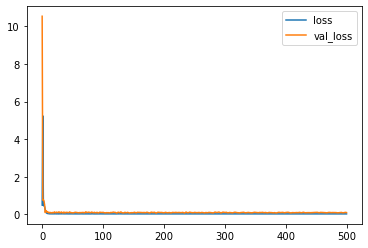

In [384]:
losses.plot()

In [385]:
df_forecast= Model_forecast(model)
df_forecast

,report_date,ICU,ICU_vented,hospitalizations,icu_crci_total,icu_crci_total_vented,total_individuals_fully_vaccinated,Daily_Covid_Num
0,2021-04-24,619.995972,418.022552,1878.955566,660.323303,440.483429,351135.84375,1203.015625
1,2021-04-25,619.996338,418.022644,1878.956421,660.323547,440.483673,351136.15625,1203.016235
2,2021-04-26,619.996399,418.022705,1878.956543,660.323608,440.483734,351136.21875,1203.016357
3,2021-04-27,619.996765,418.022797,1878.957397,660.323914,440.484039,351136.62500,1203.017334
4,2021-04-28,619.996765,418.022797,1878.957397,660.323975,440.483978,351136.62500,1203.017212
5,2021-04-29,619.996948,418.022827,1878.957886,660.324097,440.484131,351136.81250,1203.017578
6,2021-04-30,619.997009,418.022827,1878.958008,660.324158,440.484192,351136.84375,1203.017822
7,2021-05-01,619.997375,418.022980,1878.959106,660.324524,440.484467,351137.31250,1203.018677


In [370]:
model = Sequential()
model.add(Conv1D(64,activation='relu',kernel_size=(3),input_shape=(train_X.shape[1],train_X.shape[2])))
model.add(MaxPooling1D(pool_size=3,padding='same'))
model.add(Dropout(0.25))
model.add(Conv1D(32,activation='relu',kernel_size=(3)))
model.add(MaxPooling1D(pool_size=3,padding='same'))
model.add(Dropout(0.25))
model.add(LSTM(64,activation='relu',return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32,activation='relu',return_sequences=True))
model.add(LSTM(16,activation='relu',return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(8,activation='relu',return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(train_Y.shape[1]))
model.compile(optimizer='adam',loss='mse')

In [44]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 88, 64)            1408      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 30, 64)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 28, 32)            6176      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 32)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 32)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 10, 64)           

In [45]:
history = model.fit(train_X,train_Y,epochs=500,batch_size=8, validation_split=0.1, verbose=1)

Epoch 1/500
3/3 [==============================] - 1s 195ms/step - loss: 0.4452 - val_loss: 0.9394
Epoch 2/500
3/3 [==============================] - 0s 22ms/step - loss: 0.4241 - val_loss: 0.9017
Epoch 3/500
3/3 [==============================] - 0s 18ms/step - loss: 0.3891 - val_loss: 0.8406
Epoch 4/500
3/3 [==============================] - 0s 18ms/step - loss: 0.3505 - val_loss: 0.7217
Epoch 5/500
3/3 [==============================] - 0s 28ms/step - loss: 0.2668 - val_loss: 0.4315
Epoch 6/500
3/3 [==============================] - 0s 29ms/step - loss: 0.1117 - val_loss: 0.1836
Epoch 7/500
3/3 [==============================] - 0s 28ms/step - loss: 0.1452 - val_loss: 0.3076
Epoch 8/500
3/3 [==============================] - 0s 28ms/step - loss: 0.1302 - val_loss: 0.4015
Epoch 9/500
3/3 [==============================] - 0s 24ms/step - loss: 0.1264 - val_loss: 0.3600
Epoch 10/500
3/3 [==============================] - 0s 18ms/step - loss: 0.1298 - val_loss: 0.2597
Epoch 11/500
3/3 [

Epoch 84/500
3/3 [==============================] - 0s 16ms/step - loss: 0.0253 - val_loss: 0.1026
Epoch 85/500
3/3 [==============================] - 0s 16ms/step - loss: 0.0251 - val_loss: 0.1263
Epoch 86/500
3/3 [==============================] - 0s 16ms/step - loss: 0.0752 - val_loss: 0.1452
Epoch 87/500
3/3 [==============================] - 0s 15ms/step - loss: 0.0550 - val_loss: 0.1533
Epoch 88/500
3/3 [==============================] - 0s 16ms/step - loss: 0.0544 - val_loss: 0.1398
Epoch 89/500
3/3 [==============================] - 0s 17ms/step - loss: 0.0551 - val_loss: 0.1146
Epoch 90/500
3/3 [==============================] - 0s 16ms/step - loss: 0.0554 - val_loss: 0.0852
Epoch 91/500
3/3 [==============================] - 0s 16ms/step - loss: 0.0693 - val_loss: 0.0678
Epoch 92/500
3/3 [==============================] - 0s 15ms/step - loss: 0.0433 - val_loss: 0.0686
Epoch 93/500
3/3 [==============================] - 0s 16ms/step - loss: 0.0196 - val_loss: 0.1027
Epoch 94/5

3/3 [==============================] - 0s 16ms/step - loss: 0.0308 - val_loss: 0.0399
Epoch 167/500
3/3 [==============================] - 0s 16ms/step - loss: 0.0283 - val_loss: 0.0599
Epoch 168/500
3/3 [==============================] - 0s 16ms/step - loss: 0.0427 - val_loss: 0.0537
Epoch 169/500
3/3 [==============================] - 0s 16ms/step - loss: 0.0196 - val_loss: 0.0394
Epoch 170/500
3/3 [==============================] - 0s 16ms/step - loss: 0.0278 - val_loss: 0.0315
Epoch 171/500
3/3 [==============================] - 0s 16ms/step - loss: 0.0232 - val_loss: 0.0294
Epoch 172/500
3/3 [==============================] - 0s 17ms/step - loss: 0.0131 - val_loss: 0.0315
Epoch 173/500
3/3 [==============================] - 0s 16ms/step - loss: 0.0217 - val_loss: 0.0351
Epoch 174/500
3/3 [==============================] - 0s 15ms/step - loss: 0.0220 - val_loss: 0.0470
Epoch 175/500
3/3 [==============================] - 0s 16ms/step - loss: 0.0629 - val_loss: 0.0519
Epoch 176/500


3/3 [==============================] - 0s 16ms/step - loss: 0.0152 - val_loss: 0.0362
Epoch 249/500
3/3 [==============================] - 0s 17ms/step - loss: 0.0180 - val_loss: 0.0350
Epoch 250/500
3/3 [==============================] - 0s 16ms/step - loss: 0.0255 - val_loss: 0.0213
Epoch 251/500
3/3 [==============================] - 0s 16ms/step - loss: 0.0117 - val_loss: 0.0193
Epoch 252/500
3/3 [==============================] - 0s 16ms/step - loss: 0.0207 - val_loss: 0.0261
Epoch 253/500
3/3 [==============================] - 0s 15ms/step - loss: 0.0148 - val_loss: 0.0264
Epoch 254/500
3/3 [==============================] - 0s 18ms/step - loss: 0.0272 - val_loss: 0.0289
Epoch 255/500
3/3 [==============================] - 0s 18ms/step - loss: 0.0293 - val_loss: 0.0282
Epoch 256/500
3/3 [==============================] - 0s 16ms/step - loss: 0.0213 - val_loss: 0.0240
Epoch 257/500
3/3 [==============================] - 0s 17ms/step - loss: 0.0208 - val_loss: 0.0116
Epoch 258/500


3/3 [==============================] - 0s 16ms/step - loss: 0.0291 - val_loss: 0.0191
Epoch 331/500
3/3 [==============================] - 0s 16ms/step - loss: 0.0073 - val_loss: 0.0143
Epoch 332/500
3/3 [==============================] - 0s 16ms/step - loss: 0.0121 - val_loss: 0.0171
Epoch 333/500
3/3 [==============================] - 0s 16ms/step - loss: 0.0078 - val_loss: 0.0213
Epoch 334/500
3/3 [==============================] - 0s 21ms/step - loss: 0.0162 - val_loss: 0.0277
Epoch 335/500
3/3 [==============================] - 0s 30ms/step - loss: 0.0117 - val_loss: 0.0263
Epoch 336/500
3/3 [==============================] - 0s 24ms/step - loss: 0.0191 - val_loss: 0.0209
Epoch 337/500
3/3 [==============================] - 0s 29ms/step - loss: 0.0197 - val_loss: 0.0181
Epoch 338/500
3/3 [==============================] - 0s 24ms/step - loss: 0.0145 - val_loss: 0.0229
Epoch 339/500
3/3 [==============================] - 0s 22ms/step - loss: 0.0123 - val_loss: 0.0211
Epoch 340/500


Epoch 494/500
3/3 [==============================] - 0s 16ms/step - loss: 0.0105 - val_loss: 0.0171
Epoch 495/500
3/3 [==============================] - 0s 16ms/step - loss: 0.0038 - val_loss: 0.0183
Epoch 496/500
3/3 [==============================] - 0s 16ms/step - loss: 0.0065 - val_loss: 0.0205
Epoch 497/500
3/3 [==============================] - 0s 16ms/step - loss: 0.0058 - val_loss: 0.0282
Epoch 498/500
3/3 [==============================] - 0s 17ms/step - loss: 0.0147 - val_loss: 0.0285
Epoch 499/500
3/3 [==============================] - 0s 16ms/step - loss: 0.0034 - val_loss: 0.0260
Epoch 500/500
3/3 [==============================] - 0s 16ms/step - loss: 0.0117 - val_loss: 0.0216


In [46]:
losses= pd.DataFrame(history.history)

<AxesSubplot:>

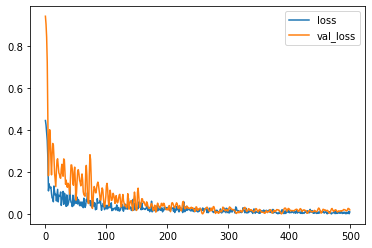

In [47]:
losses.plot()

In [48]:
forecast = model.predict(train_X[-n_forecast:])

In [49]:
df_forecast = forecaster(forecast)

In [50]:
df_forecast.columns = df.columns

In [51]:
df_forecast['report_date']= pd.to_datetime(df_forecast['report_date'])

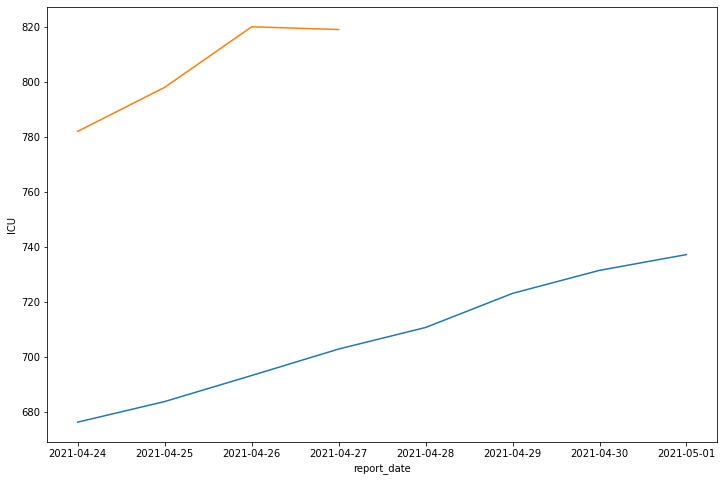

In [52]:
plt.figure(figsize=(12,8))
sns.lineplot(x='report_date',y='ICU',data=df_forecast )
sns.lineplot(x='report_date',y='ICU',data=df[-8:-4] )
plt.show()

In [53]:
df_forecast

,report_date,ICU,ICU_vented,hospitalizations,icu_crci_total,icu_crci_total_vented,total_individuals_fully_vaccinated,Daily_Covid_Num
0,2021-04-24,676.315857,466.621429,1917.632446,726.608887,497.430389,269035.96875,1090.345093
1,2021-04-25,683.799683,471.901733,1941.037720,734.442017,503.033112,273907.34375,1105.796387
2,2021-04-26,693.262817,478.578583,1970.633423,744.346924,510.117737,280067.09375,1125.334351
3,2021-04-27,702.878906,485.363434,2000.707764,754.411865,517.316895,286326.43750,1145.188110
4,2021-04-28,710.718323,490.894592,2025.224976,762.617188,523.185852,291429.25000,1161.373535
5,2021-04-29,723.107910,499.636292,2063.973145,775.585083,532.461426,299493.90625,1186.953491
6,2021-04-30,731.479492,505.542969,2090.154785,784.347473,538.728760,304943.12500,1204.237793
7,2021-05-01,737.210327,509.586456,2108.077881,790.345825,543.019226,308673.46875,1216.069702


In [54]:
df.tail(8)

,report_date,ICU,ICU_vented,hospitalizations,icu_crci_total,icu_crci_total_vented,total_individuals_fully_vaccinated,Daily_Covid_Num
116,2021-04-24,782,565,2298,833,600,358776.0,861
117,2021-04-25,798,563,2277,851,596,360354.0,707
118,2021-04-26,820,568,2336,877,605,361166.0,765
119,2021-04-27,819,554,2336,875,589,362563.0,742
120,2021-04-28,818,571,2281,877,605,365166.0,788
121,2021-04-29,825,579,2248,884,620,368403.0,688
122,2021-04-30,817,591,2201,883,632,371110.0,660
123,2021-05-01,828,593,2152,900,637,373559.0,624


## Comments

LSTM not better than hybrid 

Dropouts did not make it better

In all of them, Covid numbers predicted are higher 



In [56]:
model = Sequential()
model.add(Conv1D(64,activation='relu',kernel_size=(3),input_shape=(train_X.shape[1],train_X.shape[2])))
model.add(MaxPooling1D(pool_size=3,padding='same'))
model.add(Conv1D(32,activation='relu',kernel_size=(3)))
model.add(MaxPooling1D(pool_size=3,padding='same'))
model.add(LSTM(64,activation='relu',return_sequences=True))
model.add(LSTM(32,activation='relu',return_sequences=True))
model.add(LSTM(16,activation='relu',return_sequences=True))
model.add(LSTM(8,activation='relu',return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(train_Y.shape[1]))
model.compile(optimizer='adam',loss='mse')

In [57]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 88, 64)            1408      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 30, 64)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 28, 32)            6176      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 10, 32)            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 10, 64)            24832     
_________________________________________________________________
lstm_13 (LSTM)               (None, 10, 32)            12416     
_________________________________________________________________
lstm_14 (LSTM)               (None, 10, 16)           

In [58]:
history = model.fit(train_X,train_Y,epochs=500,batch_size=8, validation_split=0.1, verbose=1)

Epoch 1/500
3/3 [==============================] - 0s 166ms/step - loss: 0.4535 - val_loss: 0.9626
Epoch 2/500
3/3 [==============================] - 0s 17ms/step - loss: 0.4455 - val_loss: 0.9525
Epoch 3/500
3/3 [==============================] - 0s 18ms/step - loss: 0.4395 - val_loss: 0.9409
Epoch 4/500
3/3 [==============================] - 0s 17ms/step - loss: 0.4314 - val_loss: 0.9280
Epoch 5/500
3/3 [==============================] - 0s 16ms/step - loss: 0.4226 - val_loss: 0.9102
Epoch 6/500
3/3 [==============================] - 0s 16ms/step - loss: 0.4064 - val_loss: 0.8828
Epoch 7/500
3/3 [==============================] - 0s 16ms/step - loss: 0.3834 - val_loss: 0.8283
Epoch 8/500
3/3 [==============================] - 0s 18ms/step - loss: 0.3412 - val_loss: 0.6516
Epoch 9/500
3/3 [==============================] - 0s 17ms/step - loss: 0.2349 - val_loss: 0.0738
Epoch 10/500
3/3 [==============================] - 0s 16ms/step - loss: 0.2076 - val_loss: 0.2806
Epoch 11/500
3/3 [

3/3 [==============================] - 0s 17ms/step - loss: 0.0188 - val_loss: 0.0414
Epoch 165/500
3/3 [==============================] - 0s 16ms/step - loss: 0.0404 - val_loss: 0.0305
Epoch 166/500
3/3 [==============================] - 0s 16ms/step - loss: 0.0164 - val_loss: 0.0017
Epoch 167/500
3/3 [==============================] - 0s 16ms/step - loss: 0.0270 - val_loss: 0.0018
Epoch 168/500
3/3 [==============================] - 0s 16ms/step - loss: 0.0257 - val_loss: 8.0566e-04
Epoch 169/500
3/3 [==============================] - 0s 15ms/step - loss: 0.0213 - val_loss: 0.0224
Epoch 170/500
3/3 [==============================] - 0s 17ms/step - loss: 0.0291 - val_loss: 0.0079
Epoch 171/500
3/3 [==============================] - 0s 16ms/step - loss: 0.0225 - val_loss: 0.0027
Epoch 172/500
3/3 [==============================] - 0s 16ms/step - loss: 0.0232 - val_loss: 0.0048
Epoch 173/500
3/3 [==============================] - 0s 15ms/step - loss: 0.0179 - val_loss: 0.0130
Epoch 174/

3/3 [==============================] - 0s 16ms/step - loss: 0.0078 - val_loss: 7.7201e-04
Epoch 327/500
3/3 [==============================] - 0s 16ms/step - loss: 0.0216 - val_loss: 3.8430e-04
Epoch 328/500
3/3 [==============================] - 0s 16ms/step - loss: 0.0090 - val_loss: 0.0058
Epoch 329/500
3/3 [==============================] - 0s 15ms/step - loss: 0.0114 - val_loss: 0.0167
Epoch 330/500
3/3 [==============================] - 0s 16ms/step - loss: 0.0181 - val_loss: 0.0089
Epoch 331/500
3/3 [==============================] - 0s 16ms/step - loss: 0.0072 - val_loss: 0.0022
Epoch 332/500
3/3 [==============================] - 0s 16ms/step - loss: 0.0149 - val_loss: 0.0034
Epoch 333/500
3/3 [==============================] - 0s 16ms/step - loss: 0.0093 - val_loss: 0.0143
Epoch 334/500
3/3 [==============================] - 0s 16ms/step - loss: 0.0140 - val_loss: 0.0181
Epoch 335/500
3/3 [==============================] - 0s 16ms/step - loss: 0.0086 - val_loss: 0.0139
Epoch 

3/3 [==============================] - 0s 15ms/step - loss: 0.0098 - val_loss: 0.0069
Epoch 489/500
3/3 [==============================] - 0s 17ms/step - loss: 0.0051 - val_loss: 0.0034
Epoch 490/500
3/3 [==============================] - 0s 15ms/step - loss: 0.0121 - val_loss: 3.1276e-04
Epoch 491/500
3/3 [==============================] - 0s 16ms/step - loss: 0.0138 - val_loss: 9.7276e-05
Epoch 492/500
3/3 [==============================] - 0s 16ms/step - loss: 0.0110 - val_loss: 5.9781e-04
Epoch 493/500
3/3 [==============================] - 0s 16ms/step - loss: 0.0075 - val_loss: 0.0038
Epoch 494/500
3/3 [==============================] - 0s 17ms/step - loss: 0.0070 - val_loss: 0.0034
Epoch 495/500
3/3 [==============================] - 0s 16ms/step - loss: 0.0057 - val_loss: 1.4935e-04
Epoch 496/500
3/3 [==============================] - 0s 16ms/step - loss: 0.0116 - val_loss: 0.0014
Epoch 497/500
3/3 [==============================] - 0s 15ms/step - loss: 0.0111 - val_loss: 4.262

<AxesSubplot:>

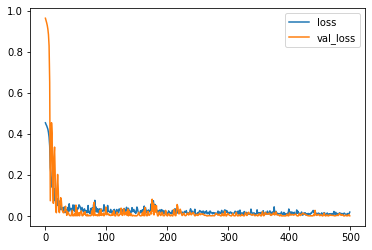

In [59]:
losses= pd.DataFrame(history.history)
losses.plot()


In [60]:
forecast = model.predict(train_X[-n_forecast:])
df_forecast = forecaster(forecast)
df_forecast.columns = df.columns
df_forecast['report_date']= pd.to_datetime(df_forecast['report_date'])

In [70]:
df_forecast

,report_date,ICU,ICU_vented,hospitalizations,icu_crci_total,icu_crci_total_vented,total_individuals_fully_vaccinated,Daily_Covid_Num
0,2021-04-24,726.496887,502.027374,2074.571777,779.132263,534.998535,301699.84375,1193.950439
1,2021-04-25,743.626465,514.113464,2128.144287,797.061462,547.822693,312849.87500,1229.316772
2,2021-04-26,756.490417,523.189819,2168.375732,810.525879,557.453308,321223.28125,1255.876099
3,2021-04-27,769.343262,532.258301,2208.572510,823.978638,567.075623,329589.43750,1282.412476
4,2021-04-28,780.795410,540.338562,2244.388672,835.965393,575.649292,337043.87500,1306.056885
5,2021-04-29,791.023865,547.555420,2276.378174,846.671265,583.306885,343701.81250,1327.174927
6,2021-04-30,802.519714,555.666565,2312.331055,858.703796,591.913330,351184.75000,1350.909668
7,2021-05-01,812.915588,563.001526,2344.843750,869.584900,599.696228,357951.62500,1372.373291


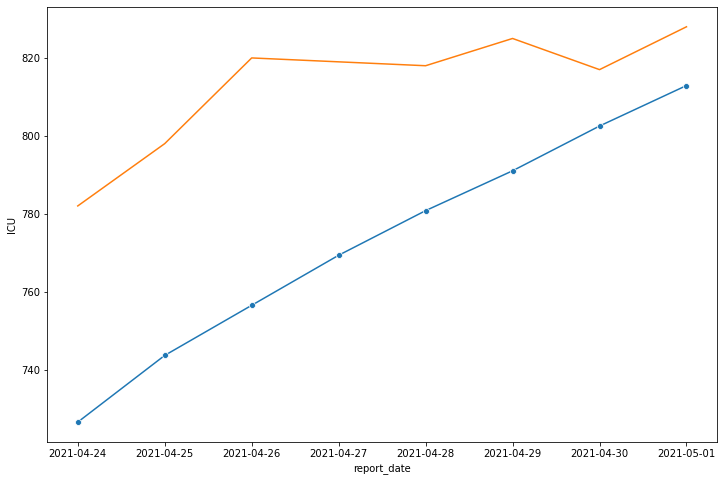

In [63]:
plt.figure(figsize=(12,8))
sns.lineplot(x='report_date',y='ICU',data=df_forecast,marker='o')
sns.lineplot(x='report_date',y='ICU',data=df[-8:] )
plt.show()

In [71]:
for i in range(1,len(df_forecast.columns)):
    print('\n')
    print(f'printing the accuracy score of {df_forecast.columns[i]}')
    score= accuracy_score(df.tail(8).iloc[1:,i],df_forecast.iloc[1:,i].values)
    print('----------------------------------------------')
    print(score)
    



printing the accuracy score of ICU
----------------------------------------------
{'mean_absolute_pcnt_error': '4.98 %', 'root_mean_squared_error': 42.14179715548934, 'mean_absolute_error': 38.326468331473215}


printing the accuracy score of ICU_vented
----------------------------------------------
{'mean_absolute_pcnt_error': '6.47 %', 'root_mean_squared_error': 35.75270743358599, 'mean_absolute_error': 34.696620396205354}


printing the accuracy score of hospitalizations
----------------------------------------------
{'mean_absolute_pcnt_error': '5.2 %', 'root_mean_squared_error': 129.95752567528694, 'mean_absolute_error': 116.15311104910714}


printing the accuracy score of icu_crci_total
----------------------------------------------
{'mean_absolute_pcnt_error': '5.26 %', 'root_mean_squared_error': 45.550617524270265, 'mean_absolute_error': 43.50123814174107}


printing the accuracy score of icu_crci_total_vented
----------------------------------------------
{'mean_absolute_pcn

In [72]:
# pd.DataFrame(index=df_forecast.columns[1:],accuracy_score(df.tail(8).iloc[1:,i],df_forecast.iloc[1:,i].values))
# for i in range(1,len(df_forecast.columns)):
#     print('\n')
#     print(f'printing the accuracy score of {df_forecast.columns[i]}')
#     score= accuracy_score(df.tail(8).iloc[1:,i],df_forecast.iloc[1:,i].values)
#     print('----------------------------------------------')
#     print(score)

SyntaxError: positional argument follows keyword argument (<ipython-input-72-d679188416f8>, line 1)

In [77]:
model = Sequential()
model.add(Conv1D(64,activation='relu',kernel_size=(3),input_shape=(train_X.shape[1],train_X.shape[2])))
model.add(MaxPooling1D(pool_size=3,padding='same'))
model.add(LSTM(64,activation='relu',return_sequences=True))
model.add(LSTM(32,activation='relu',return_sequences=True))
model.add(LSTM(16,activation='relu',return_sequences=True))
model.add(LSTM(8,activation='relu',return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(train_Y.shape[1]))
model.compile(optimizer='adam',loss='mse')

In [78]:
history = model.fit(train_X,train_Y,epochs=500,batch_size=8, validation_split=0.1, verbose=1)

Epoch 1/500
3/3 [==============================] - 1s 175ms/step - loss: 0.4596 - val_loss: 0.9595
Epoch 2/500
3/3 [==============================] - 0s 24ms/step - loss: 0.4441 - val_loss: 0.9449
Epoch 3/500
3/3 [==============================] - 0s 24ms/step - loss: 0.4323 - val_loss: 0.9273
Epoch 4/500
3/3 [==============================] - 0s 31ms/step - loss: 0.4215 - val_loss: 0.9049
Epoch 5/500
3/3 [==============================] - 0s 44ms/step - loss: 0.4060 - val_loss: 0.8713
Epoch 6/500
3/3 [==============================] - 0s 37ms/step - loss: 0.3829 - val_loss: 0.8178
Epoch 7/500
3/3 [==============================] - 0s 34ms/step - loss: 0.3661 - val_loss: 0.6960
Epoch 8/500
3/3 [==============================] - 0s 37ms/step - loss: 0.2646 - val_loss: 0.2596
Epoch 9/500
3/3 [==============================] - 0s 31ms/step - loss: 0.1039 - val_loss: 0.0035
Epoch 10/500
3/3 [==============================] - 0s 36ms/step - loss: 0.0985 - val_loss: 0.2334
Epoch 11/500
3/3 [

3/3 [==============================] - 0s 24ms/step - loss: 0.0481 - val_loss: 0.0032
Epoch 165/500
3/3 [==============================] - 0s 24ms/step - loss: 0.0513 - val_loss: 3.3744e-04
Epoch 166/500
3/3 [==============================] - 0s 24ms/step - loss: 0.0335 - val_loss: 0.0022
Epoch 167/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0248 - val_loss: 8.5400e-04
Epoch 168/500
3/3 [==============================] - 0s 24ms/step - loss: 0.0335 - val_loss: 0.0199
Epoch 169/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0169 - val_loss: 0.0342
Epoch 170/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0531 - val_loss: 0.0266
Epoch 171/500
3/3 [==============================] - 0s 23ms/step - loss: 0.0522 - val_loss: 0.0199
Epoch 172/500
3/3 [==============================] - 0s 23ms/step - loss: 0.0594 - val_loss: 0.0138
Epoch 173/500
3/3 [==============================] - 0s 24ms/step - loss: 0.0455 - val_loss: 0.0084
Epoch 

Epoch 246/500
3/3 [==============================] - 0s 42ms/step - loss: 0.0393 - val_loss: 0.0076
Epoch 247/500
3/3 [==============================] - 0s 45ms/step - loss: 0.0260 - val_loss: 0.0059
Epoch 248/500
3/3 [==============================] - 0s 43ms/step - loss: 0.0303 - val_loss: 0.0066
Epoch 249/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0223 - val_loss: 0.0088
Epoch 250/500
3/3 [==============================] - 0s 35ms/step - loss: 0.0079 - val_loss: 0.0095
Epoch 251/500
3/3 [==============================] - 0s 23ms/step - loss: 0.0109 - val_loss: 0.0109
Epoch 252/500
3/3 [==============================] - 0s 23ms/step - loss: 0.0089 - val_loss: 0.0106
Epoch 253/500
3/3 [==============================] - 0s 23ms/step - loss: 0.0090 - val_loss: 0.0134
Epoch 254/500
3/3 [==============================] - 0s 23ms/step - loss: 0.0089 - val_loss: 0.0177
Epoch 255/500
3/3 [==============================] - 0s 24ms/step - loss: 0.0161 - val_loss: 0.0201


Epoch 408/500
3/3 [==============================] - 0s 23ms/step - loss: 0.0159 - val_loss: 7.8153e-04
Epoch 409/500
3/3 [==============================] - 0s 23ms/step - loss: 0.0080 - val_loss: 0.0017
Epoch 410/500
3/3 [==============================] - 0s 24ms/step - loss: 0.0068 - val_loss: 1.7879e-04
Epoch 411/500
3/3 [==============================] - 0s 23ms/step - loss: 0.0057 - val_loss: 2.0663e-04
Epoch 412/500
3/3 [==============================] - 0s 23ms/step - loss: 0.0106 - val_loss: 1.8790e-04
Epoch 413/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0081 - val_loss: 6.0957e-04
Epoch 414/500
3/3 [==============================] - 0s 23ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 415/500
3/3 [==============================] - 0s 23ms/step - loss: 0.0092 - val_loss: 0.0027
Epoch 416/500
3/3 [==============================] - 0s 24ms/step - loss: 0.0089 - val_loss: 0.0030
Epoch 417/500
3/3 [==============================] - 0s 23ms/step - loss: 0.0079

Epoch 489/500
3/3 [==============================] - 0s 24ms/step - loss: 0.0128 - val_loss: 0.0025
Epoch 490/500
3/3 [==============================] - 0s 24ms/step - loss: 0.0069 - val_loss: 0.0039
Epoch 491/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0057 - val_loss: 7.9167e-04
Epoch 492/500
3/3 [==============================] - 0s 24ms/step - loss: 0.0100 - val_loss: 4.5591e-04
Epoch 493/500
3/3 [==============================] - 0s 24ms/step - loss: 0.0031 - val_loss: 0.0020
Epoch 494/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0067 - val_loss: 0.0018
Epoch 495/500
3/3 [==============================] - 0s 24ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 496/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0018 - val_loss: 8.4429e-04
Epoch 497/500
3/3 [==============================] - 0s 24ms/step - loss: 0.0049 - val_loss: 3.7211e-04
Epoch 498/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0071 - v

In [79]:
forecast = model.predict(train_X[-n_forecast:])
df_forecast = forecaster(forecast)
df_forecast.columns = df.columns
df_forecast['report_date']= pd.to_datetime(df_forecast['report_date'])

In [80]:
df_forecast

,report_date,ICU,ICU_vented,hospitalizations,icu_crci_total,icu_crci_total_vented,total_individuals_fully_vaccinated,Daily_Covid_Num
0,2021-04-24,717.041382,495.355957,2045.000244,769.235413,527.919678,295545.06250,1174.428345
1,2021-04-25,732.833862,506.498535,2094.390625,785.765076,539.742737,305824.71875,1207.033936
2,2021-04-26,747.773743,517.039612,2141.114502,801.402344,550.927551,315549.40625,1237.879395
3,2021-04-27,762.449768,527.394592,2187.013672,816.763428,561.914856,325102.37500,1268.179932
4,2021-04-28,775.138916,536.347534,2226.698486,830.044861,571.414551,333361.96875,1294.378418
5,2021-04-29,789.258362,546.309692,2270.856445,844.823364,581.985107,342552.59375,1323.529785
6,2021-04-30,802.706970,555.798645,2312.916504,858.899780,592.053467,351306.59375,1351.296265
7,2021-05-01,815.026367,564.490723,2351.445068,871.794189,601.276428,359325.53125,1376.731323


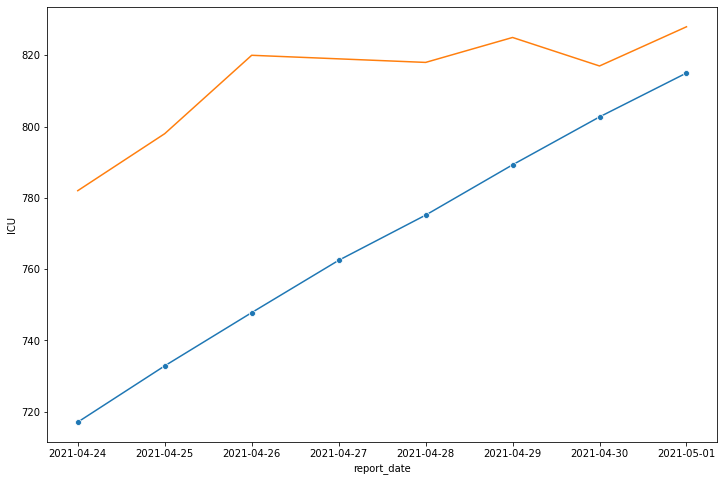

In [81]:
plt.figure(figsize=(12,8))
sns.lineplot(x='report_date',y='ICU',data=df_forecast,marker='o')
sns.lineplot(x='report_date',y='ICU',data=df[-8:] )
plt.show()

In [128]:
model = Sequential()
model.add(Conv1D(64,activation='relu',kernel_size=(3),input_shape=(train_X.shape[1],train_X.shape[2])))
model.add(MaxPooling1D(pool_size=3,padding='same'))
model.add(BatchNormalization())
model.add(Conv1D(32,activation='relu',kernel_size=(3)))
model.add(MaxPooling1D(pool_size=3,padding='same'))
model.add(BatchNormalization())
model.add(Conv1D(16,activation='relu',kernel_size=(3)))
model.add(MaxPooling1D(pool_size=3,padding='same'))
model.add(LSTM(64,activation='relu',return_sequences=True))
#model.add(Dropout(0.2))
model.add(LSTM(32,activation='relu',return_sequences=True))
model.add(LSTM(16,activation='relu',return_sequences=True))
model.add(LSTM(8,activation='relu',return_sequences=False))
#model.add(Dropout(0.2))
model.add(Dense(train_Y.shape[1]))
model.compile(optimizer='adam',loss='mse')

In [129]:
history = model.fit(train_X,train_Y,epochs=500,batch_size=8, validation_split=0.2, verbose=1)

Epoch 1/500
3/3 [==============================] - 1s 172ms/step - loss: 0.4157 - val_loss: 0.9132
Epoch 2/500
3/3 [==============================] - 0s 14ms/step - loss: 0.4017 - val_loss: 0.9027
Epoch 3/500
3/3 [==============================] - 0s 15ms/step - loss: 0.3921 - val_loss: 0.8917
Epoch 4/500
3/3 [==============================] - 0s 14ms/step - loss: 0.3804 - val_loss: 0.8803
Epoch 5/500
3/3 [==============================] - 0s 14ms/step - loss: 0.3652 - val_loss: 0.8685
Epoch 6/500
3/3 [==============================] - 0s 15ms/step - loss: 0.3448 - val_loss: 0.8560
Epoch 7/500
3/3 [==============================] - 0s 15ms/step - loss: 0.3090 - val_loss: 0.8426
Epoch 8/500
3/3 [==============================] - 0s 14ms/step - loss: 0.2436 - val_loss: 0.8277
Epoch 9/500
3/3 [==============================] - 0s 14ms/step - loss: 0.1200 - val_loss: 0.8114
Epoch 10/500
3/3 [==============================] - 0s 14ms/step - loss: 0.0503 - val_loss: 0.7999
Epoch 11/500
3/3 [

Epoch 160/500
3/3 [==============================] - 0s 14ms/step - loss: 2.5206e-05 - val_loss: 0.3415
Epoch 161/500
3/3 [==============================] - 0s 14ms/step - loss: 1.8752e-05 - val_loss: 0.3353
Epoch 162/500
3/3 [==============================] - 0s 14ms/step - loss: 1.0386e-05 - val_loss: 0.3319
Epoch 163/500
3/3 [==============================] - 0s 14ms/step - loss: 1.9318e-05 - val_loss: 0.3256
Epoch 164/500
3/3 [==============================] - 0s 16ms/step - loss: 3.5498e-05 - val_loss: 0.3195
Epoch 165/500
3/3 [==============================] - 0s 19ms/step - loss: 2.9154e-05 - val_loss: 0.3149
Epoch 166/500
3/3 [==============================] - 0s 16ms/step - loss: 4.0150e-05 - val_loss: 0.3051
Epoch 167/500
3/3 [==============================] - 0s 14ms/step - loss: 2.4318e-05 - val_loss: 0.3036
Epoch 168/500
3/3 [==============================] - 0s 14ms/step - loss: 3.8641e-05 - val_loss: 0.2962
Epoch 169/500
3/3 [==============================] - 0s 14ms/ste

Epoch 239/500
3/3 [==============================] - 0s 14ms/step - loss: 9.6027e-06 - val_loss: 0.0626
Epoch 240/500
3/3 [==============================] - 0s 14ms/step - loss: 1.6573e-05 - val_loss: 0.0628
Epoch 241/500
3/3 [==============================] - 0s 14ms/step - loss: 4.5674e-06 - val_loss: 0.0627
Epoch 242/500
3/3 [==============================] - 0s 14ms/step - loss: 8.5333e-06 - val_loss: 0.0599
Epoch 243/500
3/3 [==============================] - 0s 14ms/step - loss: 7.2133e-06 - val_loss: 0.0604
Epoch 244/500
3/3 [==============================] - 0s 13ms/step - loss: 1.2437e-05 - val_loss: 0.0582
Epoch 245/500
3/3 [==============================] - 0s 13ms/step - loss: 2.7256e-05 - val_loss: 0.0576
Epoch 246/500
3/3 [==============================] - 0s 14ms/step - loss: 1.4363e-05 - val_loss: 0.0582
Epoch 247/500
3/3 [==============================] - 0s 13ms/step - loss: 2.6713e-05 - val_loss: 0.0522
Epoch 248/500
3/3 [==============================] - 0s 13ms/ste

Epoch 318/500
3/3 [==============================] - 0s 14ms/step - loss: 1.4866e-05 - val_loss: 0.0341
Epoch 319/500
3/3 [==============================] - 0s 14ms/step - loss: 6.8396e-05 - val_loss: 0.0320
Epoch 320/500
3/3 [==============================] - 0s 14ms/step - loss: 7.9386e-05 - val_loss: 0.0338
Epoch 321/500
3/3 [==============================] - 0s 14ms/step - loss: 5.8707e-05 - val_loss: 0.0319
Epoch 322/500
3/3 [==============================] - 0s 14ms/step - loss: 3.5961e-05 - val_loss: 0.0304
Epoch 323/500
3/3 [==============================] - 0s 14ms/step - loss: 4.9618e-05 - val_loss: 0.0299
Epoch 324/500
3/3 [==============================] - 0s 14ms/step - loss: 7.6854e-05 - val_loss: 0.0277
Epoch 325/500
3/3 [==============================] - 0s 14ms/step - loss: 4.1518e-05 - val_loss: 0.0323
Epoch 326/500
3/3 [==============================] - 0s 14ms/step - loss: 4.2152e-05 - val_loss: 0.0292
Epoch 327/500
3/3 [==============================] - 0s 13ms/ste

Epoch 397/500
3/3 [==============================] - 0s 22ms/step - loss: 8.8093e-06 - val_loss: 0.0289
Epoch 398/500
3/3 [==============================] - 0s 23ms/step - loss: 9.7520e-06 - val_loss: 0.0280
Epoch 399/500
3/3 [==============================] - 0s 22ms/step - loss: 4.7297e-06 - val_loss: 0.0290
Epoch 400/500
3/3 [==============================] - 0s 22ms/step - loss: 1.0904e-05 - val_loss: 0.0287
Epoch 401/500
3/3 [==============================] - 0s 23ms/step - loss: 6.5623e-06 - val_loss: 0.0302
Epoch 402/500
3/3 [==============================] - 0s 19ms/step - loss: 9.9543e-06 - val_loss: 0.0292
Epoch 403/500
3/3 [==============================] - 0s 21ms/step - loss: 9.8399e-06 - val_loss: 0.0304
Epoch 404/500
3/3 [==============================] - 0s 22ms/step - loss: 1.6000e-05 - val_loss: 0.0284
Epoch 405/500
3/3 [==============================] - 0s 17ms/step - loss: 2.4326e-05 - val_loss: 0.0296
Epoch 406/500
3/3 [==============================] - 0s 23ms/ste

Epoch 476/500
3/3 [==============================] - 0s 21ms/step - loss: 2.3556e-05 - val_loss: 0.0309
Epoch 477/500
3/3 [==============================] - 0s 22ms/step - loss: 3.1064e-05 - val_loss: 0.0275
Epoch 478/500
3/3 [==============================] - 0s 20ms/step - loss: 3.8879e-05 - val_loss: 0.0287
Epoch 479/500
3/3 [==============================] - 0s 21ms/step - loss: 2.4887e-05 - val_loss: 0.0258
Epoch 480/500
3/3 [==============================] - 0s 18ms/step - loss: 1.8454e-05 - val_loss: 0.0278
Epoch 481/500
3/3 [==============================] - 0s 15ms/step - loss: 2.0229e-05 - val_loss: 0.0270
Epoch 482/500
3/3 [==============================] - 0s 17ms/step - loss: 1.3397e-05 - val_loss: 0.0290
Epoch 483/500
3/3 [==============================] - 0s 21ms/step - loss: 2.7045e-05 - val_loss: 0.0264
Epoch 484/500
3/3 [==============================] - 0s 22ms/step - loss: 4.0438e-05 - val_loss: 0.0298
Epoch 485/500
3/3 [==============================] - 0s 22ms/ste

<AxesSubplot:>

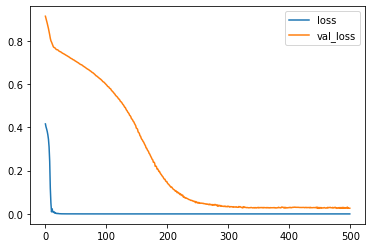

In [130]:
losses= pd.DataFrame(history.history)
losses.plot()

In [132]:
Model_forecast(model)

,report_date,ICU,ICU_vented,hospitalizations,icu_crci_total,icu_crci_total_vented,total_individuals_fully_vaccinated,Daily_Covid_Num
0,2021-04-24,722.467468,499.184448,2061.970215,774.914795,531.981934,299077.03125,1185.631226
1,2021-04-25,738.263306,510.329407,2111.371094,791.447998,543.807556,309358.87500,1218.243896
2,2021-04-26,758.762268,524.792786,2175.481201,812.903809,559.154175,322702.09375,1260.566650
3,2021-04-27,741.526733,512.632019,2121.577393,794.863708,546.250732,311483.12500,1224.981567
4,2021-04-28,730.887695,505.125397,2088.303955,783.728027,538.285706,304557.90625,1203.015869
5,2021-04-29,711.958984,491.770020,2029.105347,763.915833,524.114746,292236.87500,1163.935181
6,2021-04-30,697.851868,481.816528,1984.985840,749.150208,513.553406,283054.25000,1134.809082
7,2021-05-01,696.649719,480.968323,1981.226074,747.891907,512.653381,282271.71875,1132.327148


In [127]:
df.tail(8)

,report_date,ICU,ICU_vented,hospitalizations,icu_crci_total,icu_crci_total_vented,total_individuals_fully_vaccinated,Daily_Covid_Num
116,2021-04-24,782,565,2298,833,600,358776.0,861
117,2021-04-25,798,563,2277,851,596,360354.0,707
118,2021-04-26,820,568,2336,877,605,361166.0,765
119,2021-04-27,819,554,2336,875,589,362563.0,742
120,2021-04-28,818,571,2281,877,605,365166.0,788
121,2021-04-29,825,579,2248,884,620,368403.0,688
122,2021-04-30,817,591,2201,883,632,371110.0,660
123,2021-05-01,828,593,2152,900,637,373559.0,624
